## 강화 학습 실체 6주차 - Temporal Difference Method <br/> Quiz

Starting Q-Learning for 20000 episodes...
Episode 1000/20000 finished. Avg Reward (last 100): 0.84, Epsilon: 0.2819
Episode 2000/20000 finished. Avg Reward (last 100): 0.88, Epsilon: 0.2638
Episode 3000/20000 finished. Avg Reward (last 100): 0.89, Epsilon: 0.2456
Episode 4000/20000 finished. Avg Reward (last 100): 0.96, Epsilon: 0.2275
Episode 5000/20000 finished. Avg Reward (last 100): 0.93, Epsilon: 0.2094
Episode 6000/20000 finished. Avg Reward (last 100): 0.94, Epsilon: 0.1913
Episode 7000/20000 finished. Avg Reward (last 100): 0.96, Epsilon: 0.1731
Episode 8000/20000 finished. Avg Reward (last 100): 0.91, Epsilon: 0.1550
Episode 9000/20000 finished. Avg Reward (last 100): 0.93, Epsilon: 0.1369
Episode 10000/20000 finished. Avg Reward (last 100): 0.93, Epsilon: 0.1188
Episode 11000/20000 finished. Avg Reward (last 100): 0.94, Epsilon: 0.1006
Episode 12000/20000 finished. Avg Reward (last 100): 0.99, Epsilon: 0.0825
Episode 13000/20000 finished. Avg Reward (last 100): 0.97, Epsilon:

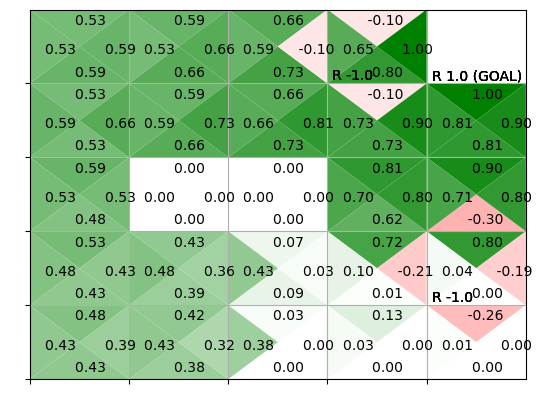

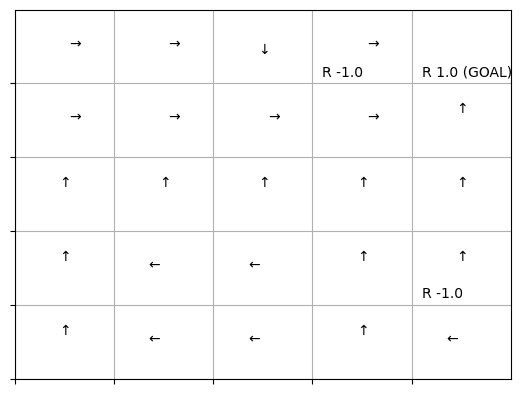

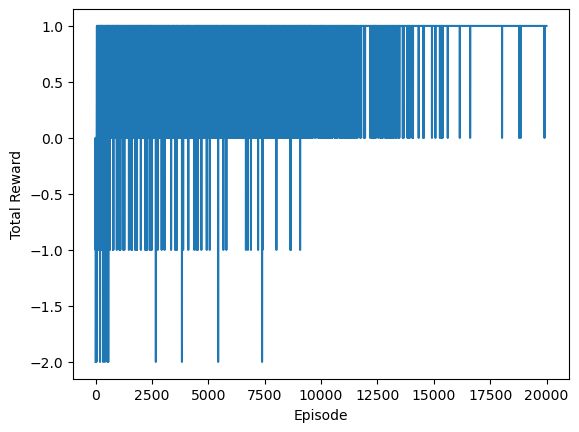

In [14]:
import numpy as np
import common.gridworld_render as render_helper
from collections import defaultdict # defaultdict 사용 추가

class GridWorld_5x5:
    def __init__(self):
        self.action_space = [0, 1, 2, 3] # UP, DOWN, LEFT, RIGHT
        self.action_meaning = {0: "UP", 1: "DOWN", 2: "LEFT", 3: "RIGHT"}
        # 5x5 보상 맵 (벽은 None)
        self.reward_map = np.array([
            [0,    0,  0, -1.0,  1.0], # Row 0: Bomb(-1), Goal(+1)
            [0,    0,  0,    0,  0.0], # Row 1
            [0, None, None,  0,  0.0], # Row 2: Walls
            [0,    0,  0,    0, -1.0], # Row 3: Bomb(-1)
            [0,    0,  0,    0,  0.0]  # Row 4: Start(0)
        ], dtype=object) # None을 포함하기 위해 dtype=object
        self.goal_state = (0, 4)
        self.bomb_states = {(0, 3), (3, 4)} # Set으로 관리
        self.wall_states = {(2, 1), (2, 2)} # Set으로 관리 (효율적)
        self.start_state = (4, 0)
        self.agent_state = self.start_state

    @property
    def height(self): return self.reward_map.shape[0]
    @property
    def width(self): return self.reward_map.shape[1]
    @property
    def shape(self): return self.reward_map.shape
    @property
    def action_size(self): return len(self.action_space) # 추가

    def actions(self): return self.action_space
    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                if (h, w) not in self.wall_states:
                    yield (h, w)

    def next_state(self, state, action):
        # 액션에 따른 이동 계산 (UP, DOWN, LEFT, RIGHT 순서 확인 필요)
        # 기존 코드: 0:UP, 1:DOWN, 2:LEFT, 3:RIGHT
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        # 경계 체크
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state # 경계 밖이면 제자리
        # 벽 체크 (Set 사용)
        elif next_state in self.wall_states:
            next_state = state # 벽이면 제자리

        return next_state

    def reward(self, state, action, next_state):
        # 보상은 도달한 상태(next_state)에 의해 결정됨
        # next_state 로직이 벽으로 못가게 하므로 None 체크는 불필요할 수 있으나 안전하게 처리
        reward_val = self.reward_map[next_state]
        # reward_val이 None이면 0을 반환 (벽에 도달하는 경우, 실제로는 발생 X)
        return 0.0 if reward_val is None else float(reward_val)

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        # 목표 지점 도달 시 또는 폭탄 지점 도달 시 종료 (여기서는 목표만 종료 조건으로)
        # 필요하다면 폭탄도 종료 조건으로 추가 가능
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    # Renderer 호출 시 wall_states 세트를 전달하도록 수정
    def render_v(self, v=None, policy=None, print_value=True):
        # Renderer가 wall_states를 받도록 수정되었다고 가정
        renderer = render_helper.Renderer(self.reward_map, self.goal_state, self.wall_states)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True, show_greedy_policy=True):
         # Renderer가 wall_states를 받도록 수정되었다고 가정
        renderer = render_helper.Renderer(self.reward_map, self.goal_state, self.wall_states)
        renderer.render_q(q, show_greedy_policy=show_greedy_policy) # 플래그 전달

import numpy as np
from collections import defaultdict
try:
    from utils import argmax
except ImportError:
    # utils.py가 없거나 경로 설정이 안된 경우 대비용 argmax 구현
    print("Warning: 'utils.argmax' not found. Using basic numpy argmax (may not handle ties randomly).")
    def argmax(xs):
        return np.argmax(xs)

class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1, action_size=4):
        self.gamma = gamma         # 할인율
        self.alpha = alpha         # 학습률
        self.epsilon = epsilon     # ε (탐험 확률)
        self.action_size = action_size
        self.Q = defaultdict(lambda: 0.0) # Q 테이블 (float으로 초기화)

    def get_action(self, state):
        # ε-greedy 정책으로 행동 선택
        if np.random.rand() < self.epsilon:
            # 탐험 (Exploration): 무작위 행동 선택
            return np.random.choice(self.action_size)
        else:
            # 활용 (Exploitation): 현재 Q값이 가장 높은 행동 선택
            # state에 대한 Q값 리스트 생성
            qs = [self.Q[state, a] for a in range(self.action_size)]
            # argmax를 사용하여 최적 행동 인덱스 반환 (utils.argmax 사용 권장)
            return argmax(qs)

    def update(self, state, action, reward, next_state, done):
        # Q-Learning 업데이트
        if done:
            target = reward  # 종료 상태에서는 다음 상태 가치가 없음
        else:
            # 다음 상태에서 가능한 모든 행동들의 Q값 중 최대값 계산
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            max_q_next = max(next_qs)
            # TD 목표 계산: R + γ * max_a' Q(S', a')
            target = reward + self.gamma * max_q_next

        # TD 오차 계산
        td_error = target - self.Q[state, action]
        # Q값 업데이트: Q(S, A) ← Q(S, A) + α * TD 오차
        self.Q[state, action] += self.alpha * td_error

# --- 하이퍼파라미터 ---
EPISODES = 20000  # 학습 에피소드 수 (충분히 크게 설정)
ALPHA = 0.1       # 학습률
GAMMA = 0.9       # 할인율
EPSILON_START = 0.3 # 초기 엡실론 값
EPSILON_END = 0.01  # 최종 엡실론 값
EPSILON_DECAY = (EPSILON_START - EPSILON_END) / (EPISODES * 0.8) # 엡실론 감쇠율 (80% 지점까지 감쇠)

# --- 초기화 ---
env = GridWorld_5x5()
# 에이전트 초기화 시 action_size 전달
agent = QLearningAgent(alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON_START, action_size=env.action_size)

# --- 학습 루프 ---
print(f"Starting Q-Learning for {EPISODES} episodes...")
total_rewards = [] # 에피소드별 보상 저장 (학습 과정 확인용)

for episode in range(EPISODES):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = agent.get_action(state)            # 행동 선택 (ε-greedy)
        next_state, reward, done = env.step(action) # 환경과 상호작용
        # Q 테이블 업데이트
        agent.update(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward

    total_rewards.append(episode_reward)

    # 엡실론 감쇠 (점점 탐험을 줄이고 활용을 늘림)
    if agent.epsilon > EPSILON_END:
        agent.epsilon -= EPSILON_DECAY
    else:
        agent.epsilon = EPSILON_END


    # 진행 상황 출력 (예: 1000 에피소드마다)
    if (episode + 1) % 1000 == 0:
        avg_reward = sum(total_rewards[-100:]) / 100 # 최근 100개 에피소드 평균 보상
        print(f"Episode {episode + 1}/{EPISODES} finished. Avg Reward (last 100): {avg_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

print("Training finished.")

# --- 결과 시각화 ---
print("\nVisualizing learned Q-values and greedy policy...")
# render_q가 wall_states set을 처리하도록 수정되었다고 가정
# show_greedy_policy=True로 설정하여 Q값과 함께 정책 화살표 표시
env.render_q(agent.Q, show_greedy_policy=True)

# (선택) 학습 곡선 시각화
try:
    from common.utils import plot_total_reward
    plot_total_reward(total_rewards)
except ImportError:
    print("\n'utils.plot_total_reward' not found. Skipping reward plot.")

## Q-Learning 기반 5x5 GridWorld 문제 해결 코드 설명

**1. 서론**

5x5 GridWorld 환경에서 최적 경로를 탐색하는 문제를 해결하기 위해 Q-Learning 알고리즘을 적용한 Python 코드 구현에 대해 설명한다. 목표는 시작 지점`(4, 0)`에서 출발하여 지정된 벽(장애물)과 페널티(벌칙) 상태를 회피하며 목표 지점`(0, 4)`에 도달하는 최적 정책(Optimal Policy) 및 최적 행동 가치 함수(Optimal Action-Value Function, Q\*)를 학습하는 것이다. 이를 위해 기존에 제공된 GridWorld 환경 코드, 렌더링 모듈, 유틸리티 함수를 기반으로 환경 정의를 수정하고, Q-Learning 에이전트를 새로 구현하였으며, 학습 및 평가를 위한 실행 스크립트를 구성하였다.

**2. 환경 구현: `GridWorld_5x5` 클래스**

문제 해결을 위한 시뮬레이션 환경은 기존 `gridworld.py` 코드를 수정하여 `GridWorld_5x5` 클래스로 구현하였다. 주요 구성 요소 및 특징은 다음과 같다.

* **그리드 구성:** 5x5 크기의 격자 환경을 정의한다. 각 셀은 상태(State)를 나타내며, 좌표 `(행, 열)`로 식별된다 (좌상단 기준 (0,0)).
* **상태 공간:** 벽을 제외한 총 23개의 유효 상태로 구성된다.
* **행동 공간:** 각 상태에서 에이전트가 취할 수 있는 행동은 상(UP), 하(DOWN), 좌(LEFT), 우(RIGHT)의 4가지 이산적 행동(Discrete Action)으로 정의된다.
* **보상 함수:** 상태 전이 시 받게 되는 보상은 다음과 같이 정의된다.
    * 목표 상태 (0, 4) 도달 시: +1.0
    * 페널티 상태 (0, 3), (3, 4) 도달 시: -1.0
    * 벽 상태 (2, 1), (2, 2): `None` 값으로 표현되며, 해당 상태로의 진입은 불가능하다.
    * 그 외 일반 상태: 0.0
* **상태 전이 함수 (`next_state`):** 에이전트의 현재 상태와 선택된 행동을 입력받아 다음 상태를 결정한다. 상태 전이는 결정론적(Deterministic)이며, 에이전트가 그리드 경계 외부 또는 벽(`self.wall_states`에 정의된 좌표 집합)으로 이동하려 할 경우 현재 상태를 유지한다.
* **상호작용 인터페이스 (`step`):** 에이전트의 행동을 입력받아 환경과의 상호작용을 1 스텝 진행시킨 후, 결과로 다음 상태(`next_state`), 보상(`reward`), 에피소드 종료 여부(`done`)를 반환한다. 에피소드는 목표 상태 도달 시 종료된다.
* **시각화 지원:** `common.gridworld_render` 모듈과의 연동을 위한 `render_v`, `render_q` 메소드를 포함한다. 렌더링 모듈은 복수의 벽 상태(`wall_states`)를 처리하도록 수정이 필요할 수 있다.

**3. Q-Learning 에이전트 구현: `QLearningAgent` 클래스**

Q-Learning 알고리즘의 핵심 로직은 `QLearningAgent` 클래스에 구현되었다. Q-Learning은 최적 행동 가치 함수 Q\*(s, a)를 학습하는 Off-policy 시간차(Temporal Difference, TD) 제어 알고리즘이다.

* **주요 구성 요소:**
    * `self.Q`: 행동 가치 함수(Q 테이블)를 저장하는 `collections.defaultdict`. 키는 `(state, action)` 튜플이며, 값은 해당 상태-행동 쌍의 추정 가치(Q값)이다. 초기값은 0.0으로 설정된다.
    * 하이퍼파라미터: 학습률 `alpha` (업데이트 강도 조절), 할인율 `gamma` (미래 보상 가치 조절), 탐험률 `epsilon` (탐험-활용 비율 조절)을 포함한다.
* **핵심 메서드:**
    * **`get_action(self, state)`:** ε-greedy(엡실론 탐욕) 정책에 따라 현재 상태에서 수행할 행동을 선택한다. `epsilon` 확률로 무작위 행동을 선택하여 탐험(Exploration)하고, `1-epsilon` 확률로 현재 Q 테이블에 기반하여 가장 높은 Q값을 갖는 행동을 선택하여 활용(Exploitation)한다. `utils.argmax` 함수를 사용하여 동일한 최대 Q값을 갖는 행동이 여러 개일 경우 무작위 선택을 지원한다.
    * **`update(self, state, action, reward, next_state, done)`:** Q 테이블을 갱신하는 핵심 로직이다. Q-Learning의 업데이트 규칙은 다음과 같다.
        `Q(S, A) ← Q(S, A) + α * [R + γ * max_a' Q(S', a') - Q(S, A)]`
        1.  **TD 목표(Target) 계산:** 에피소드 종료 시(`done=True`) 목표는 즉시 받은 보상 `R`이다. 진행 중일 경우, 다음 상태 `S'`에서 가능한 모든 행동 `a'`에 대한 Q값(`self.Q[S', a']`) 중 최댓값(`max_a' Q(S', a')`)을 찾아 할인율 `gamma`를 적용한 후 즉시 보상 `R`을 더하여 목표값을 계산한다. 이 `max` 연산자는 실제 다음 행동과 무관하게 최적 가치를 추정하므로 Off-policy 학습의 특징을 나타낸다.
        2.  **TD 오차(Error) 계산:** `TD 목표 - 현재 Q값 (self.Q[state, action])`
        3.  **Q값 업데이트:** `self.Q[state, action] += self.alpha * TD 오차`

**4. 학습 절차: `solve_quiz.py` 스크립트**

메인 스크립트(`solve_quiz.py`)는 전체 학습 과정을 관리하고 실행한다.

* **초기 설정:** `GridWorld_5x5` 환경 객체와 `QLearningAgent` 객체를 생성하고, 학습 에피소드 수, 학습률, 할인율, 엡실론 등의 하이퍼파라미터를 설정한다. 특히 엡실론 값은 학습 진행에 따라 점진적으로 감소시키는 **엡실론 감쇠(Epsilon Decay)** 전략을 적용하여 초기 탐험을 장려하고 후반부에는 학습된 정책 활용을 증대시킨다.
* **학습 루프:** 지정된 에피소드 수만큼 다음 과정을 반복한다.
    1.  각 에피소드 시작 시 환경을 초기 상태로 리셋한다.
    2.  에피소드가 종료될 때까지 다음 스텝을 반복한다:
        * `agent.get_action()`: 현재 상태에서 ε-greedy 정책으로 행동을 선택한다.
        * `env.step()`: 선택된 행동을 환경에서 실행하여 다음 상태, 보상, 종료 여부를 얻는다.
        * `agent.update()`: 얻어진 경험(`S, A, R, S', Done`)을 사용하여 Q 테이블을 업데이트한다.
        * 현재 상태를 다음 상태로 갱신한다.
    3.  에피소드 종료 후 엡실론 값을 감쇠시킨다.
* **성능 모니터링:** 일정 주기마다 에피소드별 평균 보상 등을 출력하여 학습 진행 상황을 확인한다.

**5. 결과 및 시각화**

학습 완료 후, `env.render_q(agent.Q, show_greedy_policy=True)` 함수를 호출하여 학습된 Q값과 이로부터 유도된 탐욕 정책(Greedy Policy)을 시각화한다.

* **Q값 시각화:** 각 상태 셀 내부의 색상 삼각형과 숫자는 해당 상태에서 각 행동을 취했을 때의 예상되는 장기적 보상(Q값)을 나타낸다.
* **정책 시각화:** 각 상태 셀의 화살표는 해당 상태에서 가장 높은 Q값을 갖는 최적 행동을 나타낸다.
* **결과 해석:** 성공적으로 학습된 경우, 시각화된 정책 화살표는 시작 지점에서 출발하여 벽과 페널티 지역을 효율적으로 회피하며 목표 지점에 도달하는 일관된 경로를 보여줄 것이다. 또한, `utils.plot_total_reward`를 이용한 에피소드별 보상 그래프는 학습이 진행됨에 따라 보상이 증가하고 수렴하는 경향을 보여줄 수 있다.
